In [2]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

from msm_a7_nachrs.manuscript.manuscript import *

<Figure size 432x288 with 0 Axes>

In [3]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma
import torch
import torch.nn as nn

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(32)

print(f"Using device {device}")

Using device cuda


In [5]:
import matplotlib.pyplot as plt
import numpy as np

import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [6]:
import deeptime
deeptime.__version__

'0.4.4'

In [7]:
class Tetramer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
        
        # Possible sequences of events
        self.transitionName = [["_".join([st1, st2]) for st1, st2 in itertools.product([state], self.states)]
                      for state in self.states]
    def state_to_features(self):
        sub_feat_dic = {
            'C': np.asarray([0.9, 0.1, 0.6]),
            'O': np.asarray([0.1, 0.9, 0.6])
        }
        feat = np.zeros(12)
        for i, s in enumerate(self._state):
            feat[3*i:3*i+3] = sub_feat_dic[s]
        return feat
    
    def run(self, step):
        self._trajectory = np.zeros([step, 12])
        self._trajectory_state_sub = np.zeros([step, 4])
        
        self.feat = np.random.normal(0, 1, 30)

        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        self._trajectory_state_sub[0] = [self.state_dic[sub] for sub in self._state]

        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()
            self._trajectory_state_sub[i] = [self.state_dic[sub] for sub in self._state]

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise

    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def state_trajectory(self):
        return self._trajectory_state_sub

    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CCCC",
              "CCCO", "CCOC", "COCC", "OCCC",
              "CCOO", "COOC", "OOCC", "OCCO",
              "COCO", "OCOC",
              "COOO", "OOOC", "OOCO", "OCOO",
              "OOOO"]
    
    single_states = ["C", "O"]

    state_dic = {
                'C': 0,
                'O': 1
            }

    # Probabilities matrix (transition matrix)
    transitionMatrix = [
	[0.6, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
	[0.3, 0.3, 0, 0, 0, 0.15, 0, 0, 0.15, 0.1, 0, 0, 0, 0, 0, 0], 
	[0.3, 0, 0.3, 0, 0, 0.15, 0.15, 0, 0, 0, 0.1, 0, 0, 0, 0, 0], 
	[0.3, 0, 0, 0.3, 0, 0, 0.15, 0.15, 0, 0.1, 0, 0, 0, 0, 0, 0], 
	[0.3, 0, 0, 0, 0.3, 0, 0, 0.15, 0.15, 0, 0.1, 0, 0, 0, 0, 0], 
	[0, 0.3, 0.3, 0, 0, 0.3, 0, 0, 0, 0, 0, 0.05, 0, 0, 0.05, 0], 
	[0, 0, 0.3, 0.3, 0, 0, 0.3, 0, 0, 0, 0, 0.05, 0.05, 0, 0, 0], 
	[0, 0, 0, 0.3, 0.3, 0, 0, 0.3, 0, 0, 0, 0, 0.05, 0.05, 0, 0], 
	[0, 0.3, 0, 0, 0.3, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.05, 0.05, 0], 
	[0, 0.4, 0, 0.4, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0], 
	[0, 0, 0.4, 0, 0.4, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0], 
	[0, 0, 0, 0, 0, 0.25, 0.25, 0, 0, 0.3, 0, 0.1, 0, 0, 0, 0.1], 
	[0, 0, 0, 0, 0, 0, 0.25, 0.25, 0, 0, 0.3, 0, 0.1, 0, 0, 0.1], 
	[0, 0, 0, 0, 0, 0, 0, 0.25, 0.25, 0.3, 0, 0, 0, 0.1, 0, 0.1], 
	[0, 0, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0.3, 0, 0, 0, 0.1, 0.1], 
	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.6]
    ]

In [8]:
glic_tetramer = Tetramer(0)

In [9]:
glic_tetramer.run(50000)

In [10]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

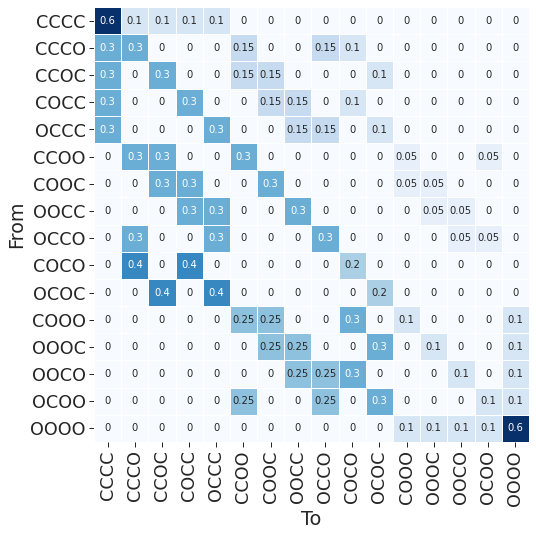

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(glic_tetramer.transitionMatrix,
            ax=ax,
            xticklabels=glic_tetramer.states,
            yticklabels=glic_tetramer.states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            )

ax.set_ylabel("From")
ax.set_xlabel("To")
plt.savefig("assets/transition_matrix_tetra.pdf", dpi=300, transparent=True)

In [12]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_tetramer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 4, data)

In [13]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= tica.transform(dataset)
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

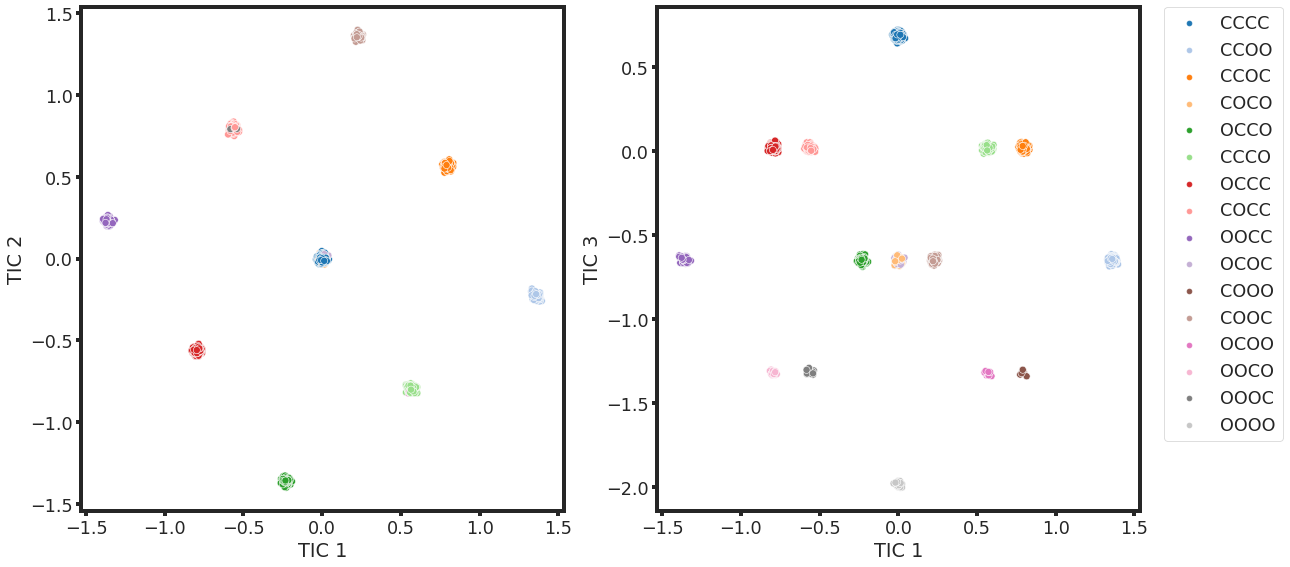

In [14]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1, 2, figsize=(18,8))
sns.scatterplot(
            x=feature_transformed[::20, 0],
            y=feature_transformed[::20, 1],
            hue=glic_tetramer.trajectory_states[::20],
            s=50, alpha=1, ax=axes[0], legend=False,
            palette='tab20')

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=feature_transformed[::20, 0],
            y=feature_transformed[::20, 2],
            hue=glic_tetramer.trajectory_states[::20],
            s=50, alpha=1, ax=axes[1],
            palette='tab20')

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")

for ax in axes:
    set_axis_boarder(ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("assets/tica_tetramer.pdf", dpi=300, transparent=True)

In [15]:
from msm_a7_nachrs.tica.sym_tica import SymTICA

symtica = SymTICA(symmetry_fold=4, lagtime=5)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
#symtica_output= symtica.transform([glic_trimer.trajectory.reshape(glic_trimer.trajectory.shape[0], 3, -1).mean(axis=2)])
symtica_concatenated= np.concatenate(symtica_output)

symmetry_fold 4


In [16]:
symtica_model_tica = symtica.fetch_model()

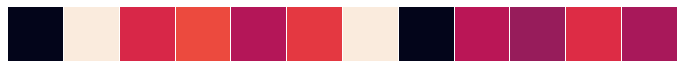

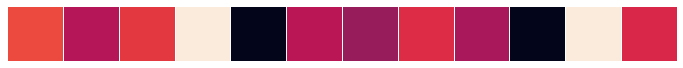

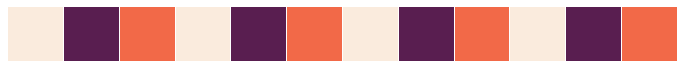

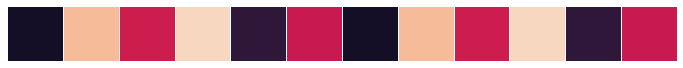

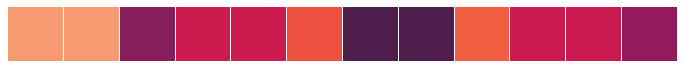

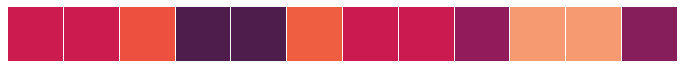

In [84]:
for i in range(6):
    fig, ax = plt.subplots(figsize=(12,1))
    sns.heatmap(tica_model_tica.instantaneous_coefficients.T[i].reshape(1, -1),
                ax=ax,
                linewidths=0.5,
                cbar=False,
                xticklabels='',
                yticklabels='',
                vmax=0.5,
                vmin=-0.5)
    plt.savefig(f"assets/tetramer_tica_{i}.pdf", dpi=300, transparent=True)

In [86]:
glic_tetramer.states

['CCCC',
 'CCCO',
 'CCOC',
 'COCC',
 'OCCC',
 'CCOO',
 'COOC',
 'OOCC',
 'OCCO',
 'COCO',
 'OCOC',
 'COOO',
 'OOOC',
 'OOCO',
 'OCOO',
 'OOOO']

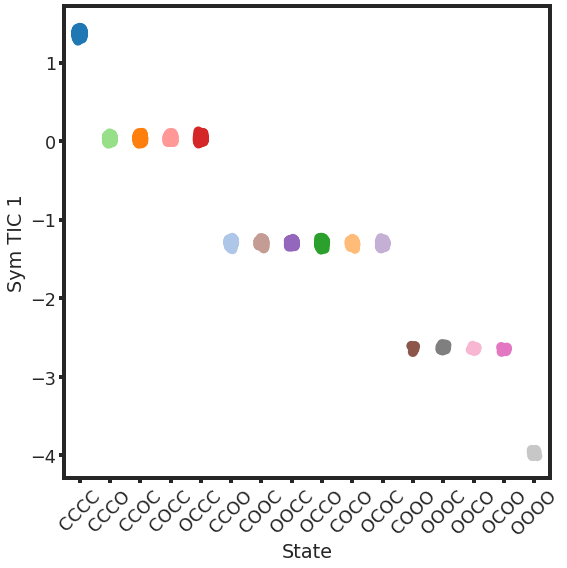

In [18]:
feature = dataset.trajectories[0]
feature_transformed = symtica.transform(feature)
fig, ax = plt.subplots(figsize=(8,8))
sns.stripplot(x=glic_tetramer.trajectory_states[::20],
                y=feature_transformed[::20, 0],
                hue=glic_tetramer.trajectory_states[::20],
                order=glic_tetramer.states,
                s=10, alpha=1, ax=ax,

                palette='tab20')
ax.set_xlabel("State")
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45)
ax.set_ylabel("Sym TIC 1")
set_axis_boarder(ax)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("assets/symtica_tetramer.pdf",
            dpi=300, transparent=True)

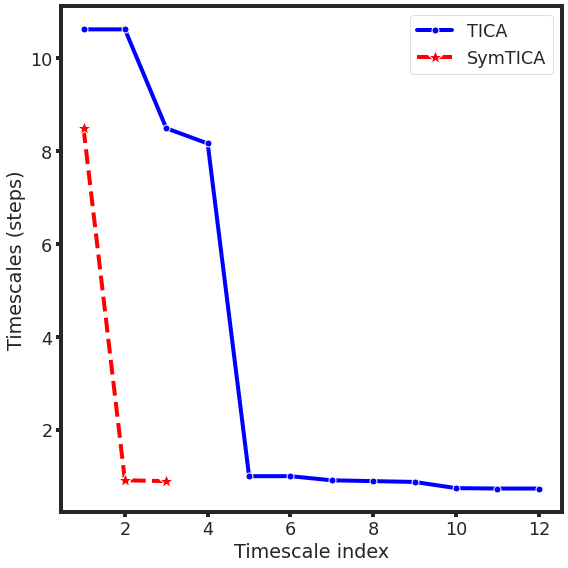

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
n_timescales=100

ax.plot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
        tica_model_tica.timescales(k=n_timescales),
             marker='o',
             linestyle='-',
             linewidth=4,
             color='blue',
             markersize=7,
             markeredgecolor='white',
             label='TICA')
ax.plot(np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1),
             symtica_model_tica.timescales(k=n_timescales),
             marker='*',
             linestyle='--',
             linewidth=4,
             color='red',
             markersize=15,
             markeredgecolor='white',
            label='SymTICA')


ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')
set_axis_boarder(ax)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("assets/tetramer_timescales.pdf", dpi=300, transparent=True)

In [16]:
from deeptime.decomposition import VAMP

vamp = VAMP(var_cutoff=None, lagtime=5)

vamp.fit(dataset)

vamp_output= vamp.transform(dataset)
vamp_concatenated= np.concatenate(vamp_output)

vamp_model = vamp.fetch_model()

In [17]:
from msm_a7_nachrs.tica.sym_tica import SymVAMP

symvamp = SymVAMP(symmetry_fold=3, lagtime=5)

symvamp.fit(dataset)

symvamp_output= symvamp.transform(dataset.trajectories[0])
symvamp_concatenated= np.concatenate(symvamp_output)

symvamp_model = symvamp.fetch_model()

<AxesSubplot: >

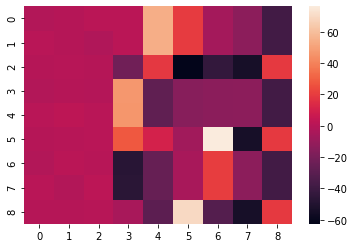

In [29]:
sns.heatmap(vamp_model.singular_vectors_left)

<AxesSubplot: >

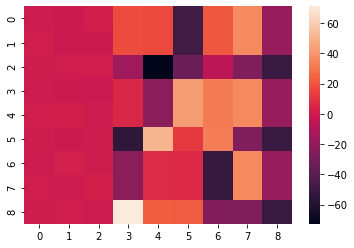

In [28]:
sns.heatmap(vamp_model.singular_vectors_right)

<AxesSubplot: >

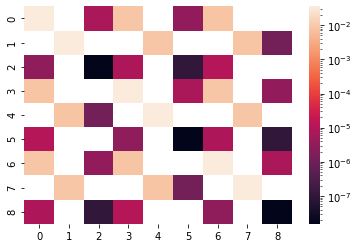

In [41]:
from matplotlib.colors import LogNorm, Normalize

sns.heatmap(vamp_model.cov_0t, norm=LogNorm())

Text(0.5, 0, 'Timescale index')

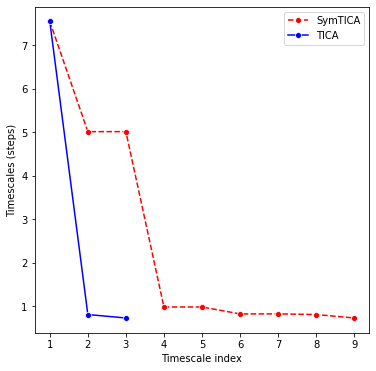

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(x=np.arange(1, vamp_model.timescales(k=n_timescales).shape[0]+1),
             y=vamp_model.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='SymTICA')
sns.lineplot(x=np.arange(1, symvamp_model.timescales(k=n_timescales).shape[0]+1),
             y=symvamp_model.timescales(k=n_timescales), marker='o', linestyle='-', color='blue', label='TICA')

ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [57]:
data_contat = np.concatenate(data)

In [101]:
glic_trimer.trajectory.shape

data_cut = []
for i in range(3):
    data_cut.append(glic_trimer.trajectory[:, i*3:(i+1)*3])

dataset_cut = TrajectoriesDataset.from_numpy(5, data_cut)

In [102]:
from deeptime.decomposition import TICA

tica_cut = TICA(var_cutoff=None, lagtime=5)

tica_cut.fit(dataset_cut)

tica_output_cut = tica_cut.transform(dataset_cut)
tica_concatenated_cut = np.concatenate(tica_output_cut)

tica_model_tica_cut = tica_cut.fetch_model()

In [103]:
states_cut = [stat[0] for stat in glic_trimer.trajectory_states] + \
[stat[1] for stat in glic_trimer.trajectory_states] + \
[stat[2] for stat in glic_trimer.trajectory_states]

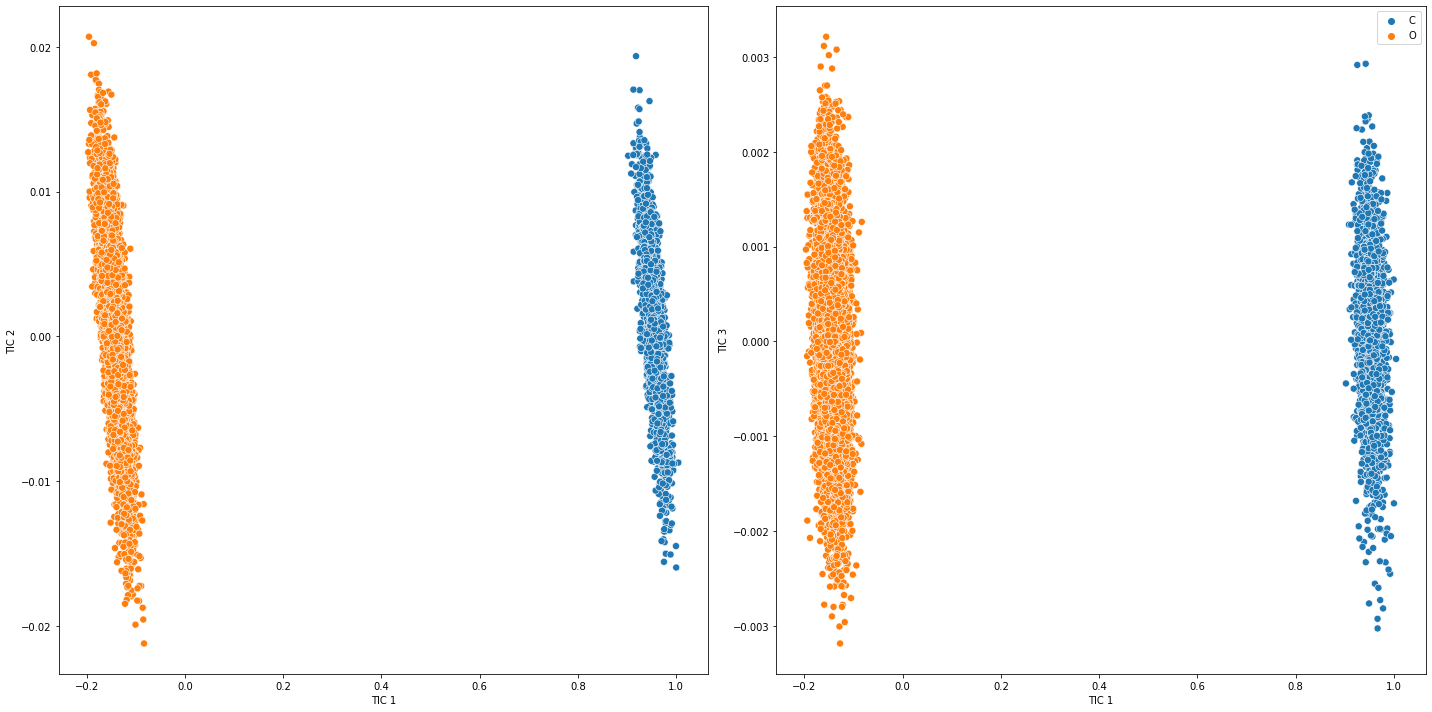

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
tica_out_all = np.concatenate([tica_cut.transform([glic_trimer.trajectory[:, i*3:(i+1)*3]])[0] for i in range(3)])
sns.scatterplot(
            x=tica_out_all[:, 0],
            y=tica_out_all[:, 1],
            hue=states_cut,
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=tica_out_all[:, 0],
            y=tica_out_all[:, 2],
            hue=states_cut,
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")
plt.legend(loc='upper right')
plt.tight_layout()

Text(0.5, 0, 'Timescale index')

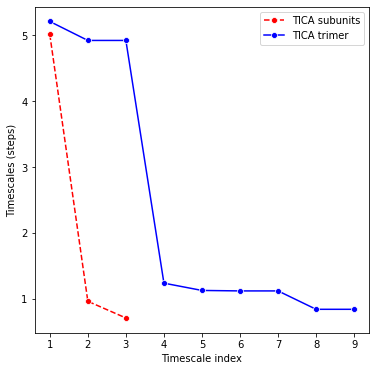

In [85]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(x=np.arange(1, tica_model_tica_cut.timescales(k=n_timescales).shape[0]+1),
             y=tica_model_tica_cut.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='TICA subunits')
sns.lineplot(x=np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
                y=tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='-', color='blue', label='TICA trimer')
ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [17]:
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [18]:
from torch.utils.data import DataLoader

#loader_train = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
loader_train = DataLoader(train_data, batch_size=20000, shuffle=True)

loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [19]:
from deeptime.decomposition.deep import vampnet_loss, vamp_score

(array([  975.,  5005., 31465.,     0.,  4870.,  5520.,     0.,   750.,
          765.,   650.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

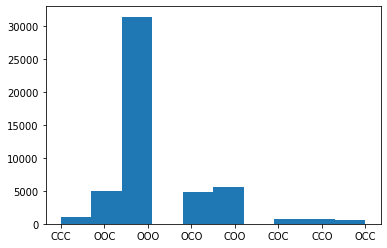

In [20]:
plt.hist(glic_trimer.trajectory_states)

In [32]:
class MultimerNet(nn.Module):
    def __init__(self, data_shape, multimer, n_states):
        super().__init__()
        self.data_shape = data_shape
        self.multimer = multimer
        self.n_states = n_states
        
        self.n_feat_per_sub = self.data_shape // self.multimer


        self.batchnorm1d = nn.BatchNorm1d(self.n_feat_per_sub)
        

        # Fully connected layers into monomer part
        self.fc1 = nn.Linear(self.n_feat_per_sub, 20)
        self.elu1 = nn.ELU()
        
        self.fc2 = nn.Linear(20, 20)
        self.elu2 = nn.ELU()

        self.fc3 = nn.Linear(20, 20)
        self.elu3 = nn.ELU()

        self.fc4 = nn.Linear(20, 20)
        self.elu4 = nn.ELU()
        
        self.fc5 = nn.Linear(20, self.n_states)
        self.softmax = nn.Softmax(dim=1)
        
        self.tanh1 = nn.Tanh()


        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
#          self.dropout1 = nn.Dropout2d(0.25)
#          self.dropout2 = nn.Dropout2d(0.5)

    # x represents our data
    def forward(self, x):
 #       x = self.batchnorm1d(x)
        
        batch_size = x.shape[0]
        
        n_feat_per_sub = int(self.data_shape / self.multimer)
        x_splits = x.reshape(batch_size, self.multimer, self.n_feat_per_sub)
        output = []
        
        x_stack = torch.permute(x_splits, (1,0,2)).reshape(batch_size * self.multimer, self.n_feat_per_sub)
        x_stack = self.batchnorm1d(x_stack)

        x_stack = self.fc1(x_stack)
        x_stack = self.elu1(x_stack)
        x_stack = self.fc2(x_stack)
        x_stack = self.elu2(x_stack)
        x_stack = self.fc3(x_stack)
        x_stack = self.elu3(x_stack)
        x_stack = self.fc4(x_stack)
        x_stack = self.elu4(x_stack)
        x_stack = self.fc5(x_stack)
        x_stack = self.softmax(x_stack) 
        
        x_splits = x_stack.reshape(self.multimer, batch_size, self.n_states).permute(1,0,2).reshape(batch_size, self.n_states * self.multimer)
        return x_splits
    

        
    
        
        
trimer_twostate_lobe = MultimerNet(data_shape=data[0].shape[1], multimer=3, n_states=2)
trimer_twostate_lobe = trimer_twostate_lobe.to(device=device)

In [33]:
from deeptime.decomposition.deep import VAMPNet
from copy import deepcopy

from typing import Optional, Union, Callable, Tuple
from deeptime.decomposition.deep import vampnet_loss, vamp_score
from deeptime.util.torch import disable_TF32, map_data
from msm_a7_nachrs.vampnet.vampnet import VAMPNet_Multimer_NOSYM

In [38]:
vampnets = [VAMPNet_Multimer_NOSYM(
                             n_states=2,
                             multimer=3,
                             lobe=deepcopy(trimer_twostate_lobe).to(device=device),
                             score_method='VAMPE',
                             learning_rate=5e-2,
                             device=device) for i in range(2)]

In [39]:
from tqdm.notebook import tqdm  # progress bar
models = [vampnet.fit(loader_train, n_epochs=n_epoch,
                    validation_loader=loader_val, progress=tqdm).fetch_model() for vampnet, n_epoch in zip(vampnets, [10, 20, 30, 40])]

VAMPNet epoch:   0%|          | 0/10 [00:00<?, ?it/s]

VAMPNet epoch:   0%|          | 0/20 [00:00<?, ?it/s]

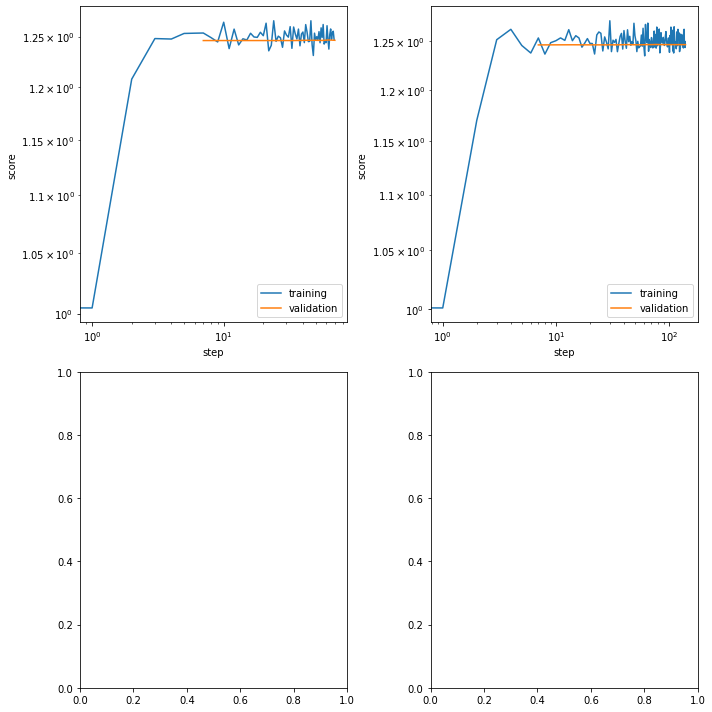

In [40]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
for vampnet, ax in zip(vampnets, axes.flatten()):
    ax.loglog(*vampnet.train_scores.T, label='training')
    ax.loglog(*vampnet.validation_scores.T, label='validation')
    ax.set_xlabel('step')
    ax.set_ylabel('score')
    ax.legend()
plt.tight_layout()

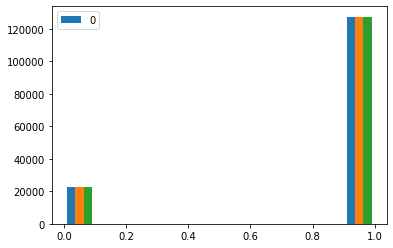

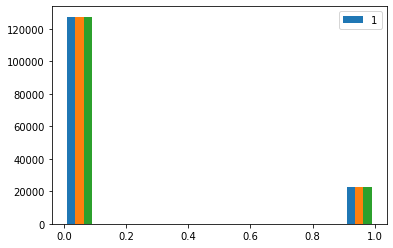

Subunit 1 ,State 1: [3.5032461608120427e-44, 1.0]
Subunit 1 ,State 2: [2.715374058936959e-08, 1.0]
Subunit 2 ,State 1: [3.5032461608120427e-44, 1.0]
Subunit 2 ,State 2: [2.715374058936959e-08, 1.0]
Subunit 3 ,State 1: [3.5032461608120427e-44, 1.0]
Subunit 3 ,State 2: [2.715374058936959e-08, 1.0]



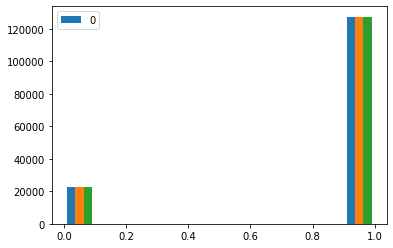

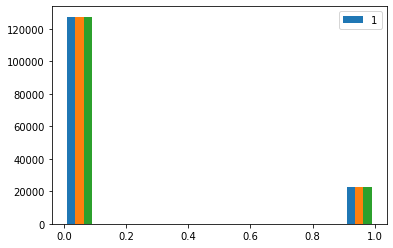

Subunit 1 ,State 1: [0.0, 1.0]
Subunit 1 ,State 2: [9.690887203817056e-09, 1.0]
Subunit 2 ,State 1: [0.0, 1.0]
Subunit 2 ,State 2: [9.690887203817056e-09, 1.0]
Subunit 3 ,State 1: [0.0, 1.0]
Subunit 3 ,State 2: [9.690887203817056e-09, 1.0]


In [41]:
for vampnet in vampnets:
    print('')
    state_probabilities = [vampnet.transform(traj) for traj in dataset.trajectories]
    state_probabilities_concat = np.concatenate(state_probabilities)
    for i in range(2):
        plt.hist(state_probabilities_concat[:,range(i, i + 2 * 3, 2)], label=str(i))
        plt.legend()
        plt.show()
    for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities_concat, axis=0), 
                                          np.max(state_probabilities_concat, axis=0))):
        
        print(f"Subunit {(ix) // 2 + 1} ,State {(ix) % 2 + 1}: [{mini}, {maxi}]")

In [43]:
import seaborn as sns
vampnet = vampnets[0]
projections = [vampnet.transform(traj) for traj in data]
projection_data_concat = np.concatenate(projections)

state_probabilities = projection_data_concat

assignments = state_probabilities.reshape(glic_trimer.trajectory.shape[0],3,2).argmax(2)

In [44]:
import itertools
all_states = []
for state in itertools.product('01', repeat=3):
    all_states.append(state)

degenerated_states = []
for i, degenerated_state in enumerate(all_states):
    all_iter_states = np.asarray([np.roll(degenerated_state, j) for j in range(3)])
    check_state_list = np.asarray(list(set(all_states[:i])))
    check_state_list = [str(i) for i in check_state_list]
    if not np.any([str(all_iter_state) in check_state_list for all_iter_state in all_iter_states]):
        degenerated_states.append(degenerated_state)
        
degenerated_states = [str(np.asarray([eval(stat) for stat in states])) for states in degenerated_states]
degenerated_states = np.asarray(degenerated_states)

In [45]:
degenerated_assignments = []
for assignment in assignments:
    for i in range(3):
        roll_assignment = np.roll(assignment, i)
        if np.any([str(roll_assignment) in degenerated_states], axis=0):
            degenerated_assignments.append(roll_assignment)
            break

assignment_labels = np.asarray([str(assignment) for assignment in degenerated_assignments])

In [46]:
def replace_dummy_2_state(dummy_assignment):
    return dummy_assignment.replace('1', 'C').replace('0', 'O').replace('2', 'D')

replace_dummy_2_state = np.vectorize(replace_dummy_2_state)
state_labels = replace_dummy_2_state(assignment_labels)
# hue_order = replace_dummy_2_state(hue_order)

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

for lab in set(state_labels):
    ax.scatter(projection_data_concat.T[0][state_labels==lab],
            projection_data_concat.T[2][state_labels==lab],
            projection_data_concat.T[4][state_labels==lab],
    #       hue=glic_dimer.trajectory_states,
    #       c=[str(stat) for stat in assignments],
            label=lab,
            s=50,
            alpha=1)

ax.set_xlabel('Subunit A')
ax.set_ylabel('Subunit B')
ax.set_zlabel('Subunit C')
plt.legend()
plt.title('Transformed state assignments')

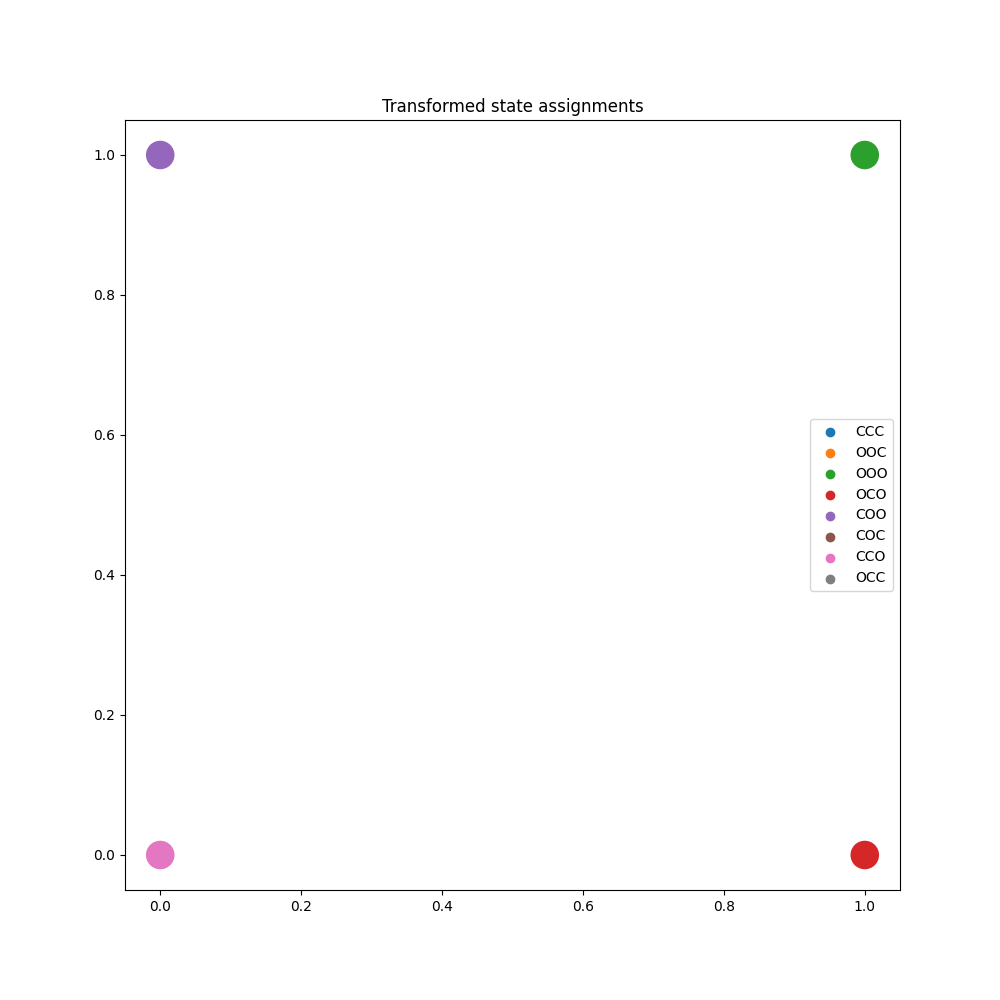

In [49]:
vampnet = vampnets[0]
projections = [vampnet.transform(traj) for traj in data]
projection_data_concat = np.concatenate(projections)

state_probabilities = projection_data_concat

assignments = state_probabilities.reshape(glic_trimer.trajectory.shape[0],3,2).argmax(2)

from sklearn.decomposition import PCA

#pca = PCA(n_components=2)
#transformed_space = pca.fit_transform(projection_data_concat)

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.scatterplot(
            x=projections[0].T[0],
            y=projections[0].T[2],
            hue=glic_trimer.trajectory_states,
#            hue=[str(stat) for stat in assignments],
            s=500,
            alpha=1,
            ax=ax)
plt.title('Transformed state assignments')
plt.show()

In [59]:
from deeptime.decomposition import VAMP

model = vampnets[0].fetch_model()

vamp_estimator = VAMP(lagtime=5, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()
print(f"VAMP-2 score under lag 1: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 1: s = 1.53


  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'timescale')

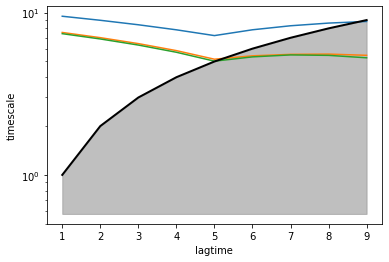

In [60]:
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

lagtimes = np.arange(1, 10, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(data) for lag in tqdm(lagtimes)]

ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')

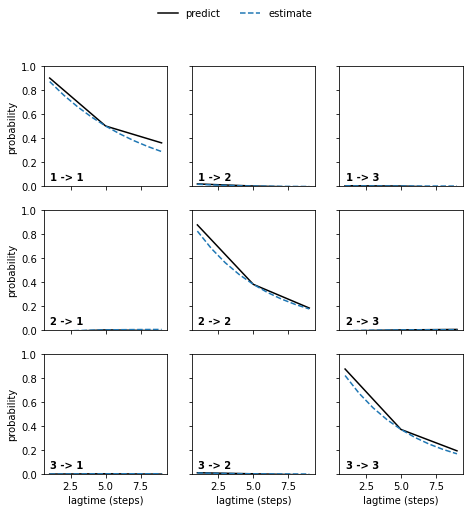

In [65]:
plot_ck_test(vamp_models[4].ck_test(vamp_models));

In [64]:
vamp = vamp_models[4]
print(vamp.lagtime)

5


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

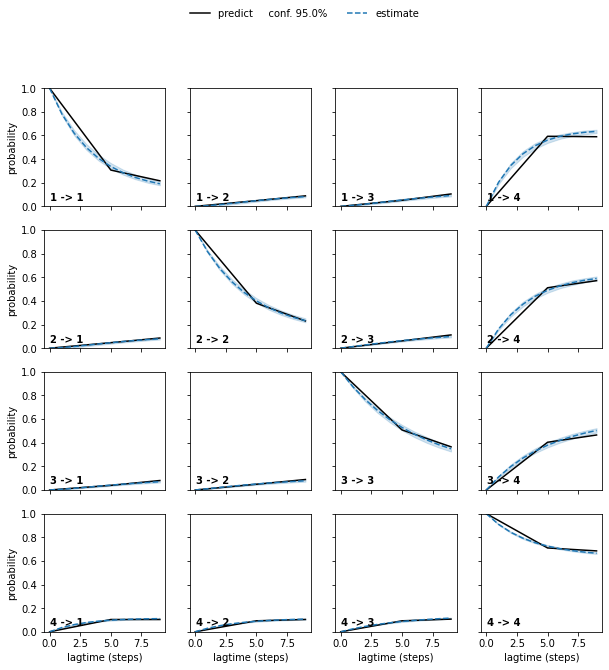

In [67]:
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM

projections = [vamp.transform(traj) for traj in data]
cluster = KMeans(4, progress=tqdm).fit_fetch(projections)
dtrajs = [cluster.transform(x) for x in projections]

bmsms = [BayesianMSM(lagtime=lag).fit_fetch(dtrajs) for lag in tqdm(range(1, 10))]
ck_test = bmsms[5].ck_test(bmsms, 4)
plot_ck_test(ck_test)

In [ ]:
msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=1, dt_traj='1 step')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

In [ ]:
nstates = 4
cktest = msm.cktest(nstates, mlags=range(5))
pyemma.plots.plot_cktest(cktest, dt=1, units='step');

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[assignments],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

In [ ]:
metastable_traj = dtrajs

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [ ]:
metastable_traj = dtrajs
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.cluster_centers[msm.active_set[highest_membership]]

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *projection_data_concat[:, :2].T, metastable_traj[0], ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['CO','CC','OO','OC'],
    ax=ax)

ax.set_xlim(-1, 4)

fig.tight_layout()